In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
matplotlib 3.10.3
numpy 1.26.4
pandas 2.3.0
sklearn 1.7.0
torch 2.7.1+cpu
cpu


# 1. preprocessing data 

## 数据加载

In [2]:
import unicodedata
import re


#因为西班牙语有一些是特殊字符，所以我们需要unicode转ascii，
# 这样值变小了，因为unicode太大
def unicode_to_ascii(s):
    #NFD是转换方法，把每一个字节拆开，Mn是重音，所以去除
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

#下面我们找个样本测试一下
# 加u代表对字符串进行unicode编码
en_sentence = u"May I borrow, this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"

print(unicode_to_ascii(en_sentence))
print(unicode_to_ascii(sp_sentence))

May I borrow, this book?
¿Puedo tomar prestado este libro?


In [3]:
def preprocess_sentence(w):
    #变为小写，去掉多余的空格，变成小写，id少一些
    w = unicode_to_ascii(w.lower().strip())

    # 在单词与跟在其后的标点符号之间插入一个空格
    # eg: "he is a boy." => "he is a boy . "
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)


    # 除了 (a-z, A-Z, ".", "?", "!", ",")，将所有字符替换为空格，你可以保留一些标点符号
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    #因为可能有多余空格，替换为一个空格，所以处理一下
    w = re.sub(r'[" "]+', " ", w)

    w = w.strip() #strip是去掉两边的空格

    return w

print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))  #¿是占用两个字节的

may i borrow , this book ?
¿ puedo tomar prestado este libro ?
b'\xc2\xbf puedo tomar prestado este libro ?'


In [4]:
#划分训练集和测试集的一个方法
split_index1 = np.random.choice(a=["train", "test"], replace=True, p=[0.9, 0.1], size=100)
split_index1

array(['train', 'test', 'train', 'train', 'train', 'train', 'train',
       'train', 'train', 'train', 'train', 'test', 'train', 'train',
       'train', 'train', 'train', 'train', 'train', 'train', 'train',
       'train', 'train', 'train', 'train', 'train', 'train', 'train',
       'train', 'train', 'train', 'train', 'train', 'test', 'test',
       'train', 'train', 'train', 'train', 'train', 'train', 'train',
       'train', 'test', 'train', 'train', 'train', 'train', 'train',
       'train', 'test', 'train', 'test', 'train', 'train', 'test',
       'train', 'train', 'train', 'train', 'train', 'train', 'train',
       'train', 'train', 'train', 'train', 'train', 'train', 'test',
       'train', 'train', 'train', 'train', 'train', 'train', 'train',
       'train', 'train', 'train', 'train', 'train', 'train', 'train',
       'train', 'train', 'train', 'train', 'train', 'train', 'train',
       'train', 'train', 'train', 'train', 'train', 'train', 'train',
       'train', 'train'], dty

## Dataset

In [7]:
# 创建一个继承自torch.utils.data.Dataset的数据集类
import torch
from torch.utils.data import Dataset
import os

class TranslationDataset(Dataset):
    """
    用于加载和处理英语-西班牙语翻译数据集的自定义Dataset类
    参数:
        path: 数据文件路径
        num_examples: 要使用的样本数量，None表示使用全部
        split: 数据集划分，可选'train'或'test'
    """
    def __init__(self, path, num_examples=None, split=None):
        # 检查是否存在缓存文件
        cache_file_en = f'{split}_en_sentences.npy' if split else 'all_en_sentences.npy'
        cache_file_sp = f'{split}_sp_sentences.npy' if split else 'all_sp_sentences.npy'
        
        # 如果缓存文件存在，直接加载
        if os.path.exists(cache_file_en) and os.path.exists(cache_file_sp):
            print(f"从缓存文件加载{split}数据...")
            self.trg = np.load(cache_file_en)
            self.src = np.load(cache_file_sp)
        else:
            print(f"从{path}读取数据并创建{split}数据集...")
            # 读取文件
            lines = open(path, encoding='UTF-8').read().strip().split('\n')
            
            # 创建空列表存储英语和西班牙语句子对
            self.en_sentences = []
            self.sp_sentences = []
            
            # 生成训练集和测试集的索引,如果num_examples为None，则使用所有行，否则使用num_examples行
            total_examples = len(lines) if num_examples is None else min(num_examples, len(lines)) 
            # 使用9:1的比例划分训练集和测试集
            split_index = np.random.choice(a=["train", "test"], replace=True, p=[0.9, 0.1], size=total_examples)
            
            # 遍历每一行，按tab分隔英语和西班牙语
            for i, line in enumerate(lines[:total_examples]):
                # 如果指定了split，则只保留对应的数据
                if split is not None and split_index[i] != split:
                    continue
                    
                # 按tab分隔获取英语和西班牙语句子
                en, sp = line.split('\t')
                
                # 对句子进行预处理（清理、标准化等）
                en = preprocess_sentence(en)
                sp = preprocess_sentence(sp)
                
                # 将处理后的句子添加到对应列表
                self.en_sentences.append(en)
                self.sp_sentences.append(sp)
            
            # 转换为numpy数组以提高效率
            self.trg = np.array(self.en_sentences) #英语(目标语言)
            self.src = np.array(self.sp_sentences) #西班牙语(源语言)
            
            # 将处理后的数据保存为numpy文件以加速后续加载
            np.save(cache_file_en, self.trg)
            np.save(cache_file_sp, self.src)
    
    def __len__(self):
        """返回数据集中的样本数量"""
        return len(self.trg)
    
    def __getitem__(self, idx):
        """返回指定索引的源语言和目标语言句子对"""
        return self.src[idx],self.trg[idx]
    

# 从spa.txt创建训练集和测试集
train_dataset = TranslationDataset('spa.txt', split='train')  # 创建训练数据集
test_dataset = TranslationDataset('spa.txt', split='test')    # 创建测试数据集


从缓存文件加载train数据...
从缓存文件加载test数据...


In [8]:
print("source: {}\ntarget: {}".format(*train_dataset[-1])) # print the last training example

source: si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado .
target: if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo .


### Tokenizer

这里有两种处理方式，分别对应着 encoder 和 decoder 的 word embedding 是否共享，这里实现不共享的方案。

In [9]:
from collections import Counter

def build_vocab(sentences_pairs):
    """
    构建英语和西班牙语的词典
    Args:
        sentences_pairs: 包含英语和西班牙语句子对的列表
    Returns:
        en_vocab: 英语词典
        sp_vocab: 西班牙语词典
    """
    # 分别存储英语和西班牙语的单词
    en_words = []
    sp_words = []
    
    # 遍历所有句子对，分别提取单词
    for en, sp in sentences_pairs:
        en_words.extend(en.split())
        sp_words.extend(sp.split())
    
    # 使用Counter统计词频
    en_vocab = Counter(en_words)
    sp_vocab = Counter(sp_words)
    
    return en_vocab, sp_vocab


In [10]:
from collections import Counter
import numpy as np

# 构建英语和西班牙语的词典
def build_vocab(sentences, min_freq=1):
    """
    构建词典函数
    参数:
        sentences: 句子列表
        min_freq: 最小词频,默认为1
    返回:
        word2idx: 词到索引的映射字典
    """
    # 初始化词典，包含特殊标记
    word2idx = {
        "[PAD]": 0,     # 填充 token
        "[BOS]": 1,     # begin of sentence
        "[UNK]": 2,     # 未知 token
        "[EOS]": 3,     # end of sentence
    }
    
    # 使用Counter统计词频
    # Counter类可以自动统计可迭代对象中每个元素出现的次数
    counter = Counter()
    for sentence in sentences:
        counter.update(sentence.split())  # split()将句子分割成单词列表
    
    # 按词频排序并添加到词典中
    idx = len(word2idx)  # 从特殊标记数量开始编号
    # 返回计数最高的前 n 个元素及其计数，若未指定 n 则返回所有元素
    for word, count in counter.most_common():
        # 只添加频率大于等于min_freq的词
        if count >= min_freq:
            word2idx[word] = idx
            idx += 1
    
    return word2idx

# 构建英语(目标语言)和西班牙语(源语言)词典
# trg代表target(目标), src代表source(源)
trg_word2idx = build_vocab(train_dataset.trg) #英语
src_word2idx = build_vocab(train_dataset.src) #西班牙语

# 创建反向映射（索引到词）
# 用于之后将模型输出的索引转换回单词
trg_idx2word = {idx: word for word, idx in trg_word2idx.items()}
src_idx2word = {idx: word for word, idx in src_word2idx.items()}
# 打印词典大小，用于检查词典构建是否正确
print(f"英语词典大小: {len(trg_word2idx)}")
print(f"西班牙语词典大小: {len(src_word2idx)}")

英语词典大小: 12504
西班牙语词典大小: 23719


In [11]:
class Tokenizer:
    def __init__(self, word2idx, idx2word, max_length=500, pad_idx=0, bos_idx=1, eos_idx=3, unk_idx=2):
        self.word2idx = word2idx  # 词到索引的映射字典
        self.idx2word = idx2word  # 索引到词的映射字典
        self.max_length = max_length  # 序列的最大长度
        self.pad_idx = pad_idx  # 填充标记的索引
        self.bos_idx = bos_idx  # 句子开始标记的索引
        self.eos_idx = eos_idx  # 句子结束标记的索引
        self.unk_idx = unk_idx  # 未知词标记的索引

    def encode(self, text_list, padding_first=False, add_bos=True, add_eos=True, return_mask=False):
        """如果padding_first == True，则padding加载前面，否则加载后面
        return_mask: 是否返回mask(掩码），mask用于指示哪些是padding的，哪些是真实的token
        """
        max_length = min(self.max_length, add_eos + add_bos + max([len(text) for text in text_list]))  # 计算实际需要的最大长度
        indices_list = []  # 初始化索引列表
        for text in text_list:  # 遍历每个文本
            indices = [self.word2idx.get(word, self.unk_idx) for word in text[:max_length - add_bos - add_eos]]  # 将文本中的词转换为索引，如果词不在词表中则使用unk_idx
            if add_bos:  # 如果需要添加句子开始标记
                indices = [self.bos_idx] + indices  # 在序列开头添加BOS标记
            if add_eos:  # 如果需要添加句子结束标记
                indices = indices + [self.eos_idx]  # 在序列末尾添加EOS标记
            if padding_first:  # 如果padding需要加在前面
                indices = [self.pad_idx] * (max_length - len(indices)) + indices  # 在序列前面添加padding
            else:  # 如果padding需要加在后面
                indices = indices + [self.pad_idx] * (max_length - len(indices))  # 在序列后面添加padding
            indices_list.append(indices)  # 将处理后的索引添加到列表中
        input_ids = torch.tensor(indices_list)  # 将索引列表转换为tensor
        masks = (input_ids == self.pad_idx).to(dtype=torch.int64)  # 创建mask，1表示padding位置，0表示实际token位置
        return input_ids if not return_mask else (input_ids, masks)  # 根据return_mask参数决定返回值

    def decode(self, indices_list, remove_bos=True, remove_eos=True, remove_pad=True, split=False):
        text_list = []  # 初始化文本列表
        for indices in indices_list:  # 遍历每个索引序列
            text = []  # 初始化当前文本
            for index in indices:  # 遍历序列中的每个索引
                word = self.idx2word.get(index, "[UNK]")  # 将索引转换为词，如果索引不在词表中则使用"[UNK]"
                if remove_bos and word == "[BOS]":  # 如果需要移除BOS标记且当前词是BOS
                    continue  # 跳过这个词
                if remove_eos and word == "[EOS]":  # 如果需要移除EOS标记且当前词是EOS
                    break  # 结束当前序列的处理
                if remove_pad and word == "[PAD]":  # 如果需要移除PAD标记且当前词是PAD
                    break  # 结束当前序列的处理
                text.append(word)  # 将词添加到当前文本中
            text_list.append(" ".join(text) if not split else text)  # 根据split参数决定返回连接后的字符串还是词列表
        return text_list  # 返回处理后的文本列表

# 两个相对于1个tokenizer的好处是embedding的参数量减少
src_tokenizer = Tokenizer(word2idx=src_word2idx, idx2word=src_idx2word)  # 创建源语言(西班牙语)的tokenizer
trg_tokenizer = Tokenizer(word2idx=trg_word2idx, idx2word=trg_idx2word)  # 创建目标语言(英语)的tokenizer

batch_text = ["hello world".split(), "tokenize text datas with batch".split(), "this is a test".split()]
indices,mask = trg_tokenizer.encode(batch_text, padding_first=False, add_bos=True, add_eos=True,return_mask=True)

print("batch_text"+'-'*10)
for raw in batch_text:
    print(raw)
print("mask"+'-'*10)
for m in mask:
    print(m)
print("indices"+'-'*10)
for index in indices:
    print(index)

batch_text----------
['hello', 'world']
['tokenize', 'text', 'datas', 'with', 'batch']
['this', 'is', 'a', 'test']
mask----------
tensor([0, 0, 0, 0, 1, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 1])
indices----------
tensor([   1, 1745,  309,    3,    0,    0,    0])
tensor([   1,    2, 2103,    2,   39,    2,    3])
tensor([  1,  23,  12,  10, 924,   3,   0])


# DataLoader

In [12]:
def collate_fn(batch):
    """
    数据批处理函数
    
    Args:
        batch: 批次数据
        src_tokenizer: 源语言tokenizer
        trg_tokenizer: 目标语言tokenizer
        device: 设备，如果指定则将tensor移至该设备
    
    Returns:
        包含编码后的tensor的字典
    """
    src_texts = [pair[0].split() for pair in batch] #取batch内第0列进行分词，赋给src_words
    trg_texts = [pair[1].split() for pair in batch] #取batch内第1列进行分词，赋给trg_words
    
    # 编码源语言输入
    encoder_inputs, encoder_inputs_mask = src_tokenizer.encode(
        src_texts, 
        padding_first=True, #padding加在前面
        add_bos=True, 
        add_eos=True, 
        return_mask=True
    )
    
    # 编码目标语言输入（用于训练时的teacher forcing）
    decoder_inputs= trg_tokenizer.encode(
        trg_texts, 
        padding_first=False, #padding加在后面
        add_bos=True, 
        add_eos=False, 
        return_mask=False
    )
    
    # 编码目标语言标签（用于计算损失）
    decoder_labels, decoder_labels_mask = trg_tokenizer.encode(
        trg_texts, 
        padding_first=False, 
        add_bos=False, 
        add_eos=True, 
        return_mask=True
    )
    
    result = {
        "encoder_inputs": encoder_inputs,
        "encoder_inputs_mask": encoder_inputs_mask,
        "decoder_inputs": decoder_inputs,
        "decoder_labels": decoder_labels,
        "decoder_labels_mask": decoder_labels_mask
    }
    
    # 如果指定了设备，将所有tensor移至该设备
    if device is not None:
        result = {k: v.to(device=device) for k, v in result.items()}
    
    return result

In [13]:
from torch.utils.data import DataLoader
sample_dl = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

#两次执行这个代码效果不一样，因为每次执行都会shuffle
for batch in sample_dl:
    for key, value in batch.items():
        print(key)
        print(value)
    break

encoder_inputs
tensor([[   0,    1,   17,    6,   72,   15,    7,    4,    3],
        [   1,   10, 3919,    7, 1753,  142, 2999,    4,    3]])
encoder_inputs_mask
tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0]])
decoder_inputs
tensor([[   1,    5,   46,   91,   14,  494,   71,    4,    0],
        [   1,    9, 2038,    6, 2008,  261,  373,   15,    4]])
decoder_labels
tensor([[   5,   46,   91,   14,  494,   71,    4,    3,    0],
        [   9, 2038,    6, 2008,  261,  373,   15,    4,    3]])
decoder_labels_mask
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0]])


# 定义模型

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    """
    序列到序列模型的编码器部分
    """
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers=1, dropout=0.0):
        """
        初始化编码器
        
        参数:
        - vocab_size: 源语言词汇表大小
        - embedding_dim: 词嵌入维度
        - hidden_size: 隐藏状态维度
        - num_layers: GRU层数
        - dropout: Dropout比率
        """
        super().__init__()
        
        # 词嵌入层 - 将输入的词索引转换为密集向量表示
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # GRU层,batch_first=True表示输入的形状为[batch_size, seq_len]
        # GRU是LSTM的简化版本,只有两个门控单元(更新门和重置门)
        self.gru = nn.GRU(
            input_size=embedding_dim,  # 输入维度,等于词嵌入维度
            hidden_size=hidden_size,   # 隐藏状态维度
            num_layers=num_layers,     # GRU层数,可以堆叠多层
            batch_first=True,          # 输入张量的第一个维度是batch_size
            dropout=dropout if num_layers > 1 else 0  # 多层时才在层间使用dropout
        )
        
        # dropout层 - 用于防止过拟合
        self.dropout = nn.Dropout(dropout)
        # 保存配置参数供其他地方使用
        self.hidden_size = hidden_size
        self.num_layers = num_layers
    
    def forward(self, src, src_mask=None, src_lengths=None):
        """
        前向传播
        
        参数:
        - src: 源语言序列 [batch_size, seq_len]
        - src_mask: 源语言序列的掩码 [batch_size, seq_len]
        - src_lengths: 源语言序列的实际长度 [batch_size]
        
        返回:
        - encoder_outputs: 编码器所有时间步的输出 [batch_size, seq_len, hidden_size]
        - hidden: 解码器初始隐藏状态 [num_layers, batch_size, hidden_size]
        """
        
        # 词嵌入并应用dropout正则化
        embedded = self.dropout(self.embedding(src))  #[batch_size, seq_len] -> [batch_size, seq_len, embedding_dim]
        
        # 通过GRU层处理序列
        # GRU的两个输出:
        # 1. encoder_outputs包含每个时间步的隐藏状态,用于注意力机制
        # 2. hidden是最后一个时间步的隐藏状态,用作解码器的初始状态
        # 通过GRU
        #[batch_size, seq_len, embedding_dim]-> encoder_outputs [batch_size, seq_len, hidden_dim]
        #[batch_size, seq_len, embedding_dim]-> hidden [num_layers, batch_size, hidden_dim]
        encoder_outputs, hidden = self.gru(embedded) 
        
        # 返回编码器所有时间步的输出和解码器初始隐藏状态
        return encoder_outputs, hidden

In [15]:
# 测试Encoder
import torch

# 创建测试参数
vocab_size = len(src_tokenizer.word2idx)
embedding_dim = 256
hidden_size = 512
num_layers = 2
dropout = 0.3
batch_size = 64
seq_len = 20

# 实例化Encoder
encoder = Encoder(vocab_size, embedding_dim, hidden_size, num_layers, dropout)

# 创建测试输入
src = torch.randint(0, vocab_size, (batch_size, seq_len))  # [batch_size, seq_len]

# 前向传播
encoder_outputs, hidden = encoder(src)

# 打印输出形状
print(f"源序列形状: {src.shape}")
print(f"编码器输出形状: {encoder_outputs.shape}")
print(f"隐藏状态形状: {hidden.shape}")

# 验证输出维度是否符合预期
assert encoder_outputs.shape == (batch_size, seq_len, hidden_size)
assert hidden.shape == (num_layers, batch_size, hidden_size)

print("Encoder测试通过!")

源序列形状: torch.Size([64, 20])
编码器输出形状: torch.Size([64, 20, 512])
隐藏状态形状: torch.Size([2, 64, 512])
Encoder测试通过!


# Bahdanau注意力

In [18]:
# 模拟 logits 和 mask
logits = torch.tensor([[1.0, 2.0, 3.0, 4.0]])
mask = torch.tensor([[1, 1, 0, 0]])  # 只让前两个位置有效

# 把无效位置设为 -inf
masked_logits = logits.masked_fill(mask == 0, float('-inf'))
masked_logits

tensor([[1., 2., -inf, -inf]])

In [17]:
class BahdanauAttention(nn.Module):
    """
    Bahdanau注意力机制
    
    参数:
        hidden_size: 隐藏状态的维度
        key_size: 键向量的维度（如果与隐藏状态不同）
        value_size: 值向量的维度（如果与隐藏状态不同）
    """
    def __init__(self, hidden_size, key_size=None):
        super().__init__()
        
        # 如果key_size和value_size未指定，则默认与hidden_size相同
        if key_size is None:
            key_size = hidden_size
            
        # 定义注意力层
        self.Wq = nn.Linear(hidden_size, hidden_size)  
        self.Wk = nn.Linear(key_size, hidden_size)  
        self.V = nn.Linear(hidden_size, 1, bias=False)  
        
    def forward(self, query, keys, values, attn_mask=None):
        """
        参数:
            query:decoder的隐藏状态 查询向量 [batch_size, hidden_size]
            keys: EO 键向量 [batch_size, src_len, key_size]
            values:EO  值向量 [batch_size, src_len, value_size]
            attn_mask: 注意力掩码 [batch_size, src_len]
            
        返回:
            context: 上下文向量 [batch_size, value_size]
            attention_weights: 注意力权重 [batch_size, src_len]
        """
        src_len = keys.size(1)  # 输入序列的长度
        
        # 将query从[batch_size, hidden_size]转换为[batch_size, 1, hidden_size]
        query = self.Wq(query).unsqueeze(1).repeat(1, src_len, 1)
        
        # 转换keys,shape=[batch_size, src_len, hidden_size]
        keys = self.Wk(keys)
        
        # 计算注意力分数
        energy = torch.tanh(keys+query)
        # [batch_size, src_len, hidden_size] -> [batch_size, src_len, 1] -> [batch_size, src_len]
        attention = self.V(energy).squeeze(2) 
        
        # 应用注意力掩码（如果提供）
        if attn_mask is not None:
            attn_mask = attn_mask * -1e16 
            attention += attn_mask #加上一个负无穷，让padding部分经过softmax后为0
        
        # 使用softmax归一化注意力权重  [batch_size, src_len]
        attention_weights = F.softmax(attention, dim=1)
        
        # 计算上下文向量,values是EO,shape=[batch_size, src_len, hidden_dim]
        context_vector = torch.mul(attention_weights.unsqueeze(-1), values).sum(dim=1) #对每一个词的score和对应的value做乘法，然后在seq_len维度上求和，得到context_vector
        # context_vector.shape = [batch size, hidden_dim]
        #attention_weights用于最后的画图
        return context_vector, attention_weights

Query shape: torch.Size([2, 8])
Keys shape: torch.Size([2, 4, 8])
Values shape: torch.Size([2, 4, 8])
Context vector shape: torch.Size([2, 8])
Attention weights shape: torch.Size([2, 4])

Attention weights:
tensor([[0.0000, 0.4765, 0.2317, 0.2918],
        [0.2452, 0.2049, 0.2382, 0.3118]], grad_fn=<SoftmaxBackward0>)
Encoder输出形状: torch.Size([1, 3, 4])
Decoder隐藏状态形状: torch.Size([1, 4])
注意力权重形状: torch.Size([1, 3, 1])
注意力权重值:
 tensor([[[0.8072],
         [0.0852],
         [0.1077]]])
上下文向量形状: torch.Size([1, 4])


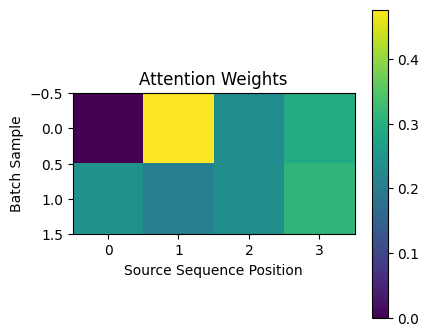

In [ ]:
# 测试BahdanauAttention
def test_bahdanau_attention():
    # 设置参数
    batch_size = 2
    hidden_size = 8
    src_len = 4
    
    # 创建输入数据
    query = torch.randn(batch_size, hidden_size)  # Decoder的隐藏状态
    keys = torch.randn(batch_size, src_len, hidden_size)  # Encoder输出
    values = torch.randn(batch_size, src_len, hidden_size)  # 通常与keys相同
    
    # 创建注意力掩码，模拟序列填充的情况
    attn_mask = torch.zeros(batch_size, src_len)
    attn_mask[0, 0] = 1  # 假设第一个样本的最后一个token是padding
    # attn_mask[1, 2:] = 1  # 假设第二个样本的最后两个tokens是padding
    
    # 初始化Bahdanau注意力机制
    attention = BahdanauAttention(hidden_size, hidden_size)
    
    # 前向传播
    context, attn_weights = attention(query, keys, values, attn_mask)
    
    # 打印结果
    print(f"Query shape: {query.shape}") # (batch_size, hidden_size)
    print(f"Keys shape: {keys.shape}") # (batch_size, src_len, hidden_size)
    print(f"Values shape: {values.shape}") # (batch_size, src_len, hidden_size)
    print(f"Context vector shape: {context.shape}") # (batch_size, hidden_size)
    print(f"Attention weights shape: {attn_weights.shape}") # (batch_size, src_len)
    
    # 验证注意力权重是否在掩码位置接近于0
    print("\nAttention weights:")
    print(attn_weights)
    
    # 可视化注意力权重
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(attn_weights.detach().numpy(), cmap='viridis')
    plt.colorbar()
    plt.title('Attention Weights')
    plt.xlabel('Source Sequence Position')
    plt.ylabel('Batch Sample')
    
    return context, attn_weights

# 运行测试
context, attn_weights = test_bahdanau_attention()


# Decoder 解码器

In [ ]:

class Decoder(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim=256,
        hidden_dim=1024,
        num_layers=1,
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim + hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size) #最后分类,词典大小是多少，就输出多少个分类
        self.dropout = nn.Dropout(0.6) #0.6可以调整的超参数
        self.attention = BahdanauAttention(hidden_dim) #注意力得到的context_vector

    def forward(self, decoder_input, hidden, encoder_outputs, attn_mask=None):
        """
        参数:
            decoder_input: 解码器的输入，形状为 [batch_size, 1]
            hidden: 解码器的隐藏状态，形状为 [batch_size, hidden_dim],第一次使用的是encoder的hidden
            encoder_outputs: 编码器的输出，形状为 [batch_size, sequence_length, hidden_dim]
            attn_mask: 注意力掩码，形状为 [batch_size, sequence_length],是encoder_inputs_mask
        
        返回:
            logits: 解码器的输出，形状为 [batch_size, 1, vocab_size]
            hidden: 解码器的隐藏状态，形状为 [batch_size, hidden_dim]
            attention_score: 注意力权重，形状为 [batch_size, sequence_length, 1]
        """
        #断言，确保输入的形状是正确的
        # decoder_input.shape = [batch size, 1]
        assert len(decoder_input.shape) == 2 and decoder_input.shape[-1] == 1, f"decoder_input.shape = {decoder_input.shape} is not valid"
        # hidden.shape = [batch size, hidden_dim]，decoder_hidden,而第一次使用的是encoder的hidden
        assert len(hidden.shape) == 2, f"hidden.shape = {hidden.shape} is not valid"
        # encoder_outputs.shape = [batch size, sequence length, hidden_dim]
        assert len(encoder_outputs.shape) == 3, f"encoder_outputs.shape = {encoder_outputs.shape} is not valid"
        # context_vector.shape = [batch_size, hidden_dim]
        
        # 注意力机制
        context_vector, attention_score = self.attention(
            query=hidden, keys=encoder_outputs, values=encoder_outputs, attn_mask=attn_mask)
        # decoder_input.shape = [batch size, 1]-->embeds.shape = [batch size, 1, embedding_dim]
        embeds = self.embedding(decoder_input)

        # context_vector.shape = [batch size, hidden_dim] -->unsqueeze(-2)增加维度 [batch size, 1, hidden_dim]
        embeds = torch.cat([context_vector.unsqueeze(-2), embeds], dim=-1) #cat上下两个维度，变成[batch size, 1, embedding_dim + hidden_dim]
        # 新的embeds.shape = [batch size, 1, embedding_dim + hidden_dim]
        seq_output, hidden = self.gru(embeds) #这里需要把前面的decode hidden再次输入，需要改进
        # seq_output.shape = [batch size, 1, hidden_dim]
        logits = self.fc(self.dropout(seq_output)) #这里需要dropout，防止过拟合
        # logits.shape = [batch size, 1, vocab size]，attention_score = [batch size, sequence length, 1]
        return logits, hidden, attention_score

In [ ]:
# 前向计算验证Decoder是否ok
batch_size = 2
seq_len = 5
hidden_dim = 32
vocab_size = 1000
embedding_dim = 64

# 创建模拟数据
decoder_input = torch.randint(0, vocab_size, (batch_size, 1))  # [batch_size, 1]
decoder_hidden = torch.randn(batch_size, hidden_dim)  # [batch_size, hidden_dim]
encoder_outputs = torch.randn(batch_size, seq_len, hidden_dim)  # [batch_size, seq_len, hidden_dim]
attn_mask = torch.ones(batch_size, seq_len)  # [batch_size, seq_len]

# 创建Decoder模型
decoder = Decoder(vocab_size, embedding_dim, hidden_dim)

# 前向计算
logits, hidden, attention_score = decoder(decoder_input, decoder_hidden, encoder_outputs, attn_mask)

# 打印输出形状
print(f"decoder_input.shape: {decoder_input.shape}") # [batch_size, 1]
print(f"decoder_hidden.shape: {decoder_hidden.shape}") # [batch_size, hidden_dim] 
print(f"encoder_outputs.shape: {encoder_outputs.shape}") # [batch_size, seq_len, hidden_dim]
print(f"logits.shape: {logits.shape}") # [batch_size,1,vocab_size]
print(f"hidden.shape: {hidden.shape}") # [num_layers, batch_size, hidden_dim]
print(f"attention_score.shape: {attention_score.shape}") # [batch_size, seq_len]

decoder_input.shape: torch.Size([2, 1])
decoder_hidden.shape: torch.Size([2, 32])
encoder_outputs.shape: torch.Size([2, 5, 32])
logits.shape: torch.Size([2, 1, 1000])
hidden.shape: torch.Size([1, 2, 32])
attention_score.shape: torch.Size([2, 5])


In [24]:
import random

class Seq2Seq(nn.Module):
    def __init__(self, input_vocab_size, output_vocab_size, embedding_dim, hidden_dim, num_layers=1, bidirectional=False, dropout=0.1):
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder(input_vocab_size, embedding_dim, hidden_dim, num_layers, dropout)
        # 如果是双向的，则Decoder的hidden_dim是encoder的两倍
        decoder_hidden_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.decoder = Decoder(output_vocab_size, embedding_dim, decoder_hidden_dim, num_layers)
        self.output_vocab_size = output_vocab_size
        self.hidden_dim = hidden_dim
        
    def forward(self, src, tgt, src_mask=None, teacher_forcing_ratio=0.5):
        # src: [batch_size, src_len]
        # tgt: [batch_size, tgt_len]
        # src_mask: [batch_size, src_len]
        batch_size = src.shape[0]
        tgt_len = tgt.shape[1]
        
        # 编码
        encoder_outputs, encoder_hidden = self.encoder(src, src_mask)
        
        # 初始化解码器输入和隐藏状态
        decoder_input = tgt[:, 0:1]  # 使用目标序列的第一个token作为初始输入
        # 获取encoder_hidden的最后一层
        if len(encoder_hidden.shape) == 3:
            # 如果encoder_hidden形状为[num_layers, batch_size, hidden_dim]
            decoder_hidden = encoder_hidden[-1]  # 只使用最后一层的隐藏状态
        else:
            # 如果已经是[batch_size, hidden_dim]
            decoder_hidden = encoder_hidden
            
        # 存储所有解码器输出
        outputs = torch.zeros(batch_size, tgt_len, self.output_vocab_size).to(src.device)
        attention_scores = torch.zeros(batch_size, tgt_len, src.shape[1]).to(src.device)
        
        # 逐个时间步解码
        for t in range(1, tgt_len):
            # 解码器前向传播
            decoder_output, decoder_hidden, attention_score = self.decoder(
                decoder_input, decoder_hidden, encoder_outputs, src_mask
            )
            
            # 存储当前输出和注意力分数
            outputs[:, t-1:t, :] = decoder_output
            attention_scores[:, t-1:t, :] = attention_score
            
            # 决定是否使用教师强制
            teacher_force = random.random() < teacher_forcing_ratio
            
            # 获取当前预测的token
            top1 = decoder_output.argmax(2)
            
            # 下一个输入：如果使用教师强制，则使用实际目标；否则使用预测
            decoder_input = tgt[:, t:t+1] if teacher_force else top1
        
        # 处理最后一个时间步
        decoder_output, _, attention_score = self.decoder(
            decoder_input, decoder_hidden, encoder_outputs, src_mask
        )
        outputs[:, -1:, :] = decoder_output
        attention_scores[:, -1:, :] = attention_score
        
        return outputs, attention_scores
    
    def translate(self, src, src_mask=None, max_len=50, sos_idx=1, eos_idx=3):
        """
        用于推理/翻译
        
        参数:
            src: 源语言输入 [batch_size, src_len]
            src_mask: 源语言掩码 [batch_size, src_len]
            max_len: 生成的最大长度
            sos_idx: 起始符索引
            eos_idx: 结束符索引
            
        返回:
            predictions: 预测的目标语言序列 [batch_size, max_len]
            attention_scores: 注意力分数 [batch_size, max_len, src_len]
        """
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        # 编码
        encoder_outputs, encoder_hidden = self.encoder(src, src_mask)
        
        # 初始化解码器输入（起始符）
        decoder_input = torch.LongTensor([[sos_idx]] * batch_size).to(src.device)
        
        # 获取encoder_hidden的最后一层
        if len(encoder_hidden.shape) == 3:
            # 如果encoder_hidden形状为[num_layers, batch_size, hidden_dim]
            decoder_hidden = encoder_hidden[-1]  # 只使用最后一层的隐藏状态
        else:
            # 如果已经是[batch_size, hidden_dim]
            decoder_hidden = encoder_hidden
        
        # 存储预测和注意力分数
        predictions = torch.zeros(batch_size, max_len, dtype=torch.long).to(src.device)
        attention_scores = torch.zeros(batch_size, max_len, src_len).to(src.device)
        
        # 记录每个样本是否已完成生成（遇到EOS）
        finished = torch.zeros(batch_size, dtype=torch.bool).to(src.device)
        
        # 逐步解码
        for t in range(max_len):
            # 解码器前向传播
            decoder_output, decoder_hidden, attention_score = self.decoder(
                decoder_input, decoder_hidden, encoder_outputs, src_mask
            )
            
            # 获取当前步的预测和注意力分数
            top1 = decoder_output.argmax(2)
            predictions[:, t:t+1] = top1
            attention_scores[:, t:t+1, :] = attention_score
            
            # 检查是否所有样本都已完成
            finished = finished | (top1.squeeze(1) == eos_idx)
            if finished.all():
                break
                
            # 使用当前预测作为下一步的输入
            decoder_input = top1
            
        return predictions, attention_scores

# Sequence2Sequence

In [ ]:
import random

class Seq2Seq(nn.Module):
    def __init__(self, input_vocab_size, output_vocab_size, embedding_dim, hidden_dim, num_layers=1, bidirectional=False, dropout=0.1):
        super(Seq2Seq, self).__init__()
        # 初始化编码器，输入词表大小、词嵌入维度、隐藏层维度、层数和dropout
        self.encoder = Encoder(input_vocab_size, embedding_dim, hidden_dim, num_layers, dropout)
        # 如果是双向的，则Decoder的hidden_dim是encoder的两倍
        decoder_hidden_dim = hidden_dim * 2 if bidirectional else hidden_dim
        # 初始化解码器，输出词表大小、词嵌入维度、解码器隐藏层维度和层数
        self.decoder = Decoder(output_vocab_size, embedding_dim, decoder_hidden_dim, num_layers)
        # 保存输出词表大小和隐藏层维度，供后续使用
        self.output_vocab_size = output_vocab_size
        self.hidden_dim = hidden_dim
        
    def forward(self, src, tgt, src_mask=None, teacher_forcing_ratio=0.5):
        # src: [batch_size, src_len] - 源序列输入
        # tgt: [batch_size, tgt_len] - 目标序列输入
        # src_mask: [batch_size, src_len] - 源序列的掩码
        # teacher_forcing_ratio: 使用教师强制的概率
        batch_size = src.shape[0]
        tgt_len = tgt.shape[1]
        
        # 通过编码器获取编码器输出和最终隐藏状态
        encoder_outputs, encoder_hidden = self.encoder(src, src_mask)
        
        # 初始化解码器输入和隐藏状态
        decoder_input = tgt[:, 0:1]  # 使用目标序列的第一个token作为初始输入
        # 获取encoder_hidden的最后一层作为解码器的初始隐藏状态
        if len(encoder_hidden.shape) == 3:
            # 如果encoder_hidden形状为[num_layers, batch_size, hidden_dim]
            decoder_hidden = encoder_hidden[-1]  # 只使用最后一层的隐藏状态
        else:
            # 如果已经是[batch_size, hidden_dim]
            decoder_hidden = encoder_hidden
            
        # 创建张量存储所有时间步的解码器输出和注意力分数
        outputs = torch.zeros(batch_size, tgt_len, self.output_vocab_size).to(src.device)
        attention_scores = torch.zeros(batch_size, tgt_len, src.shape[1]).to(src.device)
        
        # 逐个时间步解码，从第1个时间步开始（第0个是初始输入）
        for t in range(1, tgt_len):
            # 解码器单步前向传播，获取当前输出、更新后的隐藏状态和注意力分数
            decoder_output, decoder_hidden, attention_score = self.decoder(
                decoder_input, decoder_hidden, encoder_outputs, src_mask
            )
            
            # 保存当前时间步的输出和注意力分数
            outputs[:, t-1:t, :] = decoder_output
            attention_scores[:, t-1:t, :] = attention_score
            
            # 随机决定是否使用教师强制
            teacher_force = random.random() < teacher_forcing_ratio
            
            # 获取当前预测的token（概率最大的词）
            top1 = decoder_output.argmax(2)
            
            # 确定下一个时间步的输入：如果使用教师强制，则使用真实目标词；否则使用预测词
            decoder_input = tgt[:, t:t+1] if teacher_force else top1
        
        # 单独处理最后一个时间步，因为前面的循环少处理了一步
        decoder_output, _, attention_score = self.decoder(
            decoder_input, decoder_hidden, encoder_outputs, src_mask
        )
        outputs[:, -1:, :] = decoder_output
        attention_scores[:, -1:, :] = attention_score
        
        return outputs, attention_scores
    
    def translate(self, src, src_mask=None, max_len=50, sos_idx=1, eos_idx=3):
        """
        用于推理/翻译
        
        参数:
            src: 源语言输入 [batch_size, src_len]
            src_mask: 源语言掩码 [batch_size, src_len]
            max_len: 生成的最大长度
            sos_idx: 起始符索引
            eos_idx: 结束符索引
            
        返回:
            predictions: 预测的目标语言序列 [batch_size, max_len]
            attention_scores: 注意力分数 [batch_size, max_len, src_len]
        """
        # 获取输入的batch大小和序列长度
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        # 首先通过编码器编码源序列
        encoder_outputs, encoder_hidden = self.encoder(src, src_mask)
        
        # 创建解码器的初始输入（batch个起始符号）
        decoder_input = torch.LongTensor([[sos_idx]] * batch_size).to(src.device)
        
        # 处理编码器隐藏状态，确保维度正确
        if len(encoder_hidden.shape) == 3:
            # 如果是多层的隐藏状态，只取最后一层
            decoder_hidden = encoder_hidden[-1]
        else:
            # 如果已经是单层，直接使用
            decoder_hidden = encoder_hidden
        
        # 创建张量存储预测序列和注意力分数
        predictions = torch.zeros(batch_size, max_len, dtype=torch.long).to(src.device)
        attention_scores = torch.zeros(batch_size, max_len, src_len).to(src.device)
        
        # 创建标记张量，记录每个样本是否已生成结束符号
        finished = torch.zeros(batch_size, dtype=torch.bool).to(src.device)
        
        # 自回归解码：逐步生成目标序列
        for t in range(max_len):
            # 解码器单步前向传播
            decoder_output, decoder_hidden, attention_score = self.decoder(
                decoder_input, decoder_hidden, encoder_outputs, src_mask
            )
            
            # 获取当前时间步的预测和注意力分数
            top1 = decoder_output.argmax(2)  # 选择概率最大的词
            predictions[:, t:t+1] = top1
            attention_scores[:, t:t+1, :] = attention_score
            
            # 更新完成标记：如果预测到结束符号，则标记为完成
            finished = finished | (top1.squeeze(1) == eos_idx)
            # 如果所有样本都完成，提前结束解码
            if finished.all():
                break
                
            # 将当前预测作为下一步的输入，继续解码
            decoder_input = top1
            
        return predictions, attention_scores